***Libraries***

In [8]:
import sys
import pandas as pd
import numpy as np
import sklearn as skl
import tensorflow as tf
import scikeras as sck
from tqdm import tqdm
from sklearn.model_selection import PredefinedSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

***Data preprocessing***

In [3]:
#################################################### Data Preprocessing ####################################################
# Import the data
return_data = pd.read_pickle('returns_chars_panel.pkl')
return_data['date'] = pd.to_datetime(return_data['date'])
print(return_data)

macro_data = pd.read_pickle('macro_timeseries.pkl')
macro_data['date'] = pd.to_datetime(macro_data['date'])
print(macro_data)

original_data = pd.merge(return_data, macro_data, how='inner', on='date')
print(original_data)

# Preparation for Grid Search
# Split a small portion of data for experiments
exp_size = 0.00001
n_exp = int(original_data.shape[0] * exp_size)
exp_data = original_data.iloc[:n_exp, ]
X_exp = exp_data.drop(['ret', 'excess_ret', 'rfree', 'permno', 'date'], axis=1)
y_exp = exp_data['excess_ret']
print(X_exp)
print(y_exp)
X = X_exp.values
y = y_exp.values

# Split the data manually (keep the data sequence in time-series)
train_size = 0.8
test_size = 1 - train_size

n_observations = X.shape[0]
n_train = int(n_observations * train_size)
X_train, X_test = X[:n_train, ], X[n_train:, ]
y_train, y_test = y[:n_train, ], y[n_train:, ]

# Standardise the data
standard_scaler = skl.preprocessing.StandardScaler()
standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

# Index-generating function for rolling-window time-series cross validation
each_window_size = int(0.2 * X_train.shape[0])
n_train_window = int(0.75 * each_window_size)
n_test_window = each_window_size - n_train_window


def rolling_window_index_generator(X_train, train_window_size=n_train_window, test_window_size=n_test_window,
                                   step_size=1):
    n_samples = X_train.shape[0]
    indices = np.arange(n_samples)
    for start in range(0, n_samples - train_window_size - test_window_size + 1, step_size):
        train_end = start + train_window_size
        test_end = train_end + test_window_size

        if test_end <= n_samples:
            train_indices = indices[start:train_end]
            test_indices = indices[train_end:test_end]

            yield train_indices, test_indices


# Implement rolling-window time-series cross validation for hyperparameter grid search
val_scores_dict = defaultdict(list)


# Get a function to transfer the list types in params.items() to tuple types
# for further use when we use these tuples as the keys of val_scores_dict
def make_hashable(params):
    hashable_params = {}
    for key, value in params.items():
        if isinstance(value, list):
            hashable_params[key] = tuple(value)
        else:
            hashable_params[key] = value
    return hashable_params

              date  permno  excess_ret       ret     rfree     mvel1  \
0       1986-02-01   10000   -0.262610 -0.257143  0.005467 -0.375440   
1       1986-03-01   10000    0.360335  0.365385  0.005050 -0.496811   
2       1986-04-01   10000   -0.103717 -0.098592  0.005125 -0.401783   
3       1986-05-01   10000   -0.227831 -0.222656  0.005175 -0.435735   
4       1986-06-01   10000   -0.009883 -0.005025  0.004858 -0.534203   
...            ...     ...         ...       ...       ...       ...   
3739444 2016-08-01   93436   -0.097265 -0.097023  0.000242  0.948225   
3739445 2016-09-01   93436   -0.037915 -0.037640  0.000275  0.940011   
3739446 2016-10-01   93436   -0.031253 -0.030878  0.000375  0.936380   
3739447 2016-11-01   93436   -0.042553 -0.042128  0.000425  0.936096   
3739448 2016-12-01   93436    0.127822  0.128247  0.000425  0.929911   

             beta    betasq     chmom    dolvol  ...    stdacc     stdcf  \
0        0.000000  0.000000  0.000000  0.000000  ...  0.000

***Neural Network model with 2 hidden layers***

I assume that NN2 is the best performing model in (NN2, NN3, NN4)

In order to save time, I have run the hyperparameter optimization and the optimal result was:
Optimised hyperparameters for 2 layers: {'model__activation_func': 'sigmoid',
                                          'model__dropout_rate': 0.0,
                                          'model__learning_rate': 0.01,
                                          'model__neurons_n': (256, 128),
                                          'model__optimizer': 'adam',
                                          'model__regularize_terms': None}
& Average validation score: -15.530594442895104

In [4]:
# Neural Network 2 Function
def neural_net_2(input_shape, optimizer, learning_rate, activation_func, neurons_n, dropout_rate, regularize_terms,
                 loss_func='mse', metrics_func=['mae']):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dense(neurons_n[0], activation=activation_func, kernel_regularizer=regularize_terms))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_n[1], activation=activation_func, kernel_regularizer=regularize_terms))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer_instance = tf.keras.optimizers.get(optimizer)
    optimizer_instance.learning_rate = learning_rate
    model.compile(optimizer=optimizer_instance, loss=loss_func, metrics=metrics_func)
    return model

val_scores_dict_2 = defaultdict(list)

# Train models with optimised hyperparameters
NN_2 = neural_net_2(input_shape=(X_train.shape[1],),
                    optimizer='adam',
                    learning_rate=0.01,
                    activation_func='sigmoid',
                    dropout_rate=0.0,
                    neurons_n=(256, 128),
                    regularize_terms=None)

X_NN = original_data.drop(['ret', 'excess_ret', 'rfree', 'permno', 'date'], axis=1)
y_NN = original_data['excess_ret']
date = original_data['date']


def expanding_window_indices(start_date, end_date, step_size='1Y', val_size='4Y', test_size='1Y'):
    date_range = pd.date_range(start=start_date, end=end_date, freq=step_size)
    indices = []
    for end_val in date_range:
        start = pd.Timestamp(start_date)
        end_train = end_val - pd.DateOffset(years=int(test_size[:-1])) - pd.DateOffset(years=int(val_size[:-1]))
        if end_train < start:
            continue
        train_mask = (date >= start) & (date <= end_train)
        val_mask = (date > end_train) & (date <= (end_train + pd.DateOffset(years=int(val_size[:-1]))))
        test_mask = (date > (end_train + pd.DateOffset(years=int(val_size[:-1])))) & (date <= end_val)
        if test_mask.any():
            indices.append((train_mask, val_mask, test_mask))
    return indices


# Generate the expanding window indices
expanding_indices = expanding_window_indices('1986-02-01', '2016-12-01')

r2_oos_2 = []

for train_mask, val_mask, test_mask in tqdm(expanding_indices):
    X_train, y_train = X_NN.loc[train_mask].values, y_NN.loc[train_mask].values
    X_val, y_val = X_NN.loc[val_mask].values, y_NN.loc[val_mask].values
    X_test, y_test = X_NN.loc[test_mask].values, y_NN.loc[test_mask].values

    NN2_history = NN_2.fit(X_train, y_train, epochs=100, batch_size=10000,
                           validation_data=(X_val, y_val), verbose=0,
                           callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])
    
    predictions = NN_2.predict(X_test)
    r2 = r2_score(y_test, predictions)
    r2_oos_2.append(r2)

r2_oos_2_mean = np.mean(r2_oos_2)
print(r2_oos_2_mean)

  0%|          | 0/25 [00:00<?, ?it/s]

2494/2494 ━━━━━━━━━━━━━━━━━━━━ 2s 713us/step


  4%|▍         | 1/25 [00:05<02:18,  5.75s/it]

2551/2551 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step


  8%|▊         | 2/25 [00:11<02:07,  5.55s/it]

2705/2705 ━━━━━━━━━━━━━━━━━━━━ 2s 582us/step


 12%|█▏        | 3/25 [00:15<01:54,  5.21s/it]

2989/2989 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step


 16%|█▌        | 4/25 [00:22<02:00,  5.74s/it]

3075/3075 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step


 20%|██        | 5/25 [00:28<01:54,  5.71s/it]

3248/3248 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step


 24%|██▍       | 6/25 [00:35<02:01,  6.38s/it]

3376/3376 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step


 28%|██▊       | 7/25 [00:45<02:15,  7.51s/it]

3337/3337 ━━━━━━━━━━━━━━━━━━━━ 2s 573us/step


 32%|███▏      | 8/25 [00:54<02:16,  8.01s/it]

3155/3155 ━━━━━━━━━━━━━━━━━━━━ 2s 533us/step


 36%|███▌      | 9/25 [01:02<02:08,  8.06s/it]

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step


 40%|████      | 10/25 [01:10<01:58,  7.90s/it]

2884/2884 ━━━━━━━━━━━━━━━━━━━━ 2s 529us/step


 44%|████▍     | 11/25 [01:22<02:07,  9.14s/it]

2688/2688 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step


 48%|████▊     | 12/25 [01:32<02:02,  9.42s/it]

2535/2535 ━━━━━━━━━━━━━━━━━━━━ 2s 707us/step


 52%|█████▏    | 13/25 [01:49<02:20, 11.72s/it]

2497/2497 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step


 56%|█████▌    | 14/25 [02:04<02:18, 12.61s/it]

2510/2510 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step


 60%|██████    | 15/25 [02:12<01:53, 11.35s/it]

2520/2520 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step


 64%|██████▍   | 16/25 [02:23<01:40, 11.19s/it]

2554/2554 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step


 68%|██████▊   | 17/25 [02:32<01:25, 10.63s/it]

2451/2451 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


 72%|███████▏  | 18/25 [02:44<01:16, 10.91s/it]

2195/2195 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step


 76%|███████▌  | 19/25 [02:58<01:11, 11.85s/it]

2134/2134 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step


 80%|████████  | 20/25 [03:10<00:59, 11.86s/it]

2105/2105 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step


 84%|████████▍ | 21/25 [03:20<00:45, 11.31s/it]

2073/2073 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step


 88%|████████▊ | 22/25 [03:35<00:37, 12.56s/it]

2056/2056 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step


 92%|█████████▏| 23/25 [03:46<00:23, 11.97s/it]

2115/2115 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step


 96%|█████████▌| 24/25 [04:17<00:17, 17.85s/it]

2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step


100%|██████████| 25/25 [04:31<00:00, 10.86s/it]

-0.025062117248647802


***Variable Importance Analysis***

First, for all stock characteristics, get variable importance by setting one predictor at a time to zero and finding the decrease in out of sample R2. Show a table of the 10 most important variables according to this measure, and give an economic interpretation.

In [5]:
def variable_importance(X, y, feature_name, model, baseline_r2):
    importances = {}
    
    # Iterate over all features
    for i in range(X.shape[1]):  
        X_temp = X.copy()
        X_temp[:, i] = 0  # Set the ith feature to zero
        
        y_pred = model.predict(X_temp)
        
        ss_res = np.sum((y - y_pred.T) ** 2)
        ss_tot = np.sum((y) ** 2)
        r2_out_of_sample = 1 - (ss_res / ss_tot)
        
        # "Importance" is the decrease in OOS R2
        importances[i] = (feature_name[i], (baseline_r2 - r2_out_of_sample))
        
        print(f"Variable '{feature_name[i]}' set to zero. New R²: {r2_out_of_sample}, Importance: {importances[i]}")

    return importances

# Get the feature name index from X_NN
feature_name = X_NN.columns

# Calculate variable importance for the best model
importances = variable_importance(X_test, y_test, feature_name, model=NN_2, baseline_r2=r2_oos_2_mean)

# Sort importance in descending order
importances_sorted = sorted(importances.items(), key=lambda item: item[1][1], reverse=True)

# Display top 10 most important variables
top_10_important_vars = importances_sorted[:10]

2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
Variable 'mvel1' set to zero. New R²: -0.0326453512778504, Importance: ('mvel1', 0.007583234029202596)
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step
Variable 'beta' set to zero. New R²: -0.034787476418790986, Importance: ('beta', 0.009725359170143184)
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step
Variable 'betasq' set to zero. New R²: -0.03335882907254373, Importance: ('betasq', 0.008296711823895925)
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step
Variable 'chmom' set to zero. New R²: -0.031228858271239224, Importance: ('chmom', 0.006166741022591422)
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step
Variable 'dolvol' set to zero. New R²: -0.03269451907944054, Importance: ('dolvol', 0.007632401830792741)
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step
Variable 'idiovol' set to zero. New R²: -0.03407412267282606, Importance: ('idiovol', 0.009012005424178255)
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step
Variable 'indmom' set to zero. New R²: -0.032171977312

In [6]:
print("the top 10 important variables are:")
top_10_important_vars

the top 10 important variables are:


[(94, ('dp', 0.5489164917810818)),
 (90, ('retvol', 0.017746076836097097)),
 (12, ('turn', 0.014237716989361954)),
 (89, ('maxret', 0.013463631764134582)),
 (7, ('mom1m', 0.01253828876788467)),
 (11, ('pricedelay', 0.011086605982648452)),
 (88, ('ill', 0.011000905354797492)),
 (103, ('ntis', 0.010782505251466974)),
 (47, ('pchcapx_ia', 0.01078137143903703)),
 (58, ('quick', 0.010769165509676455))]

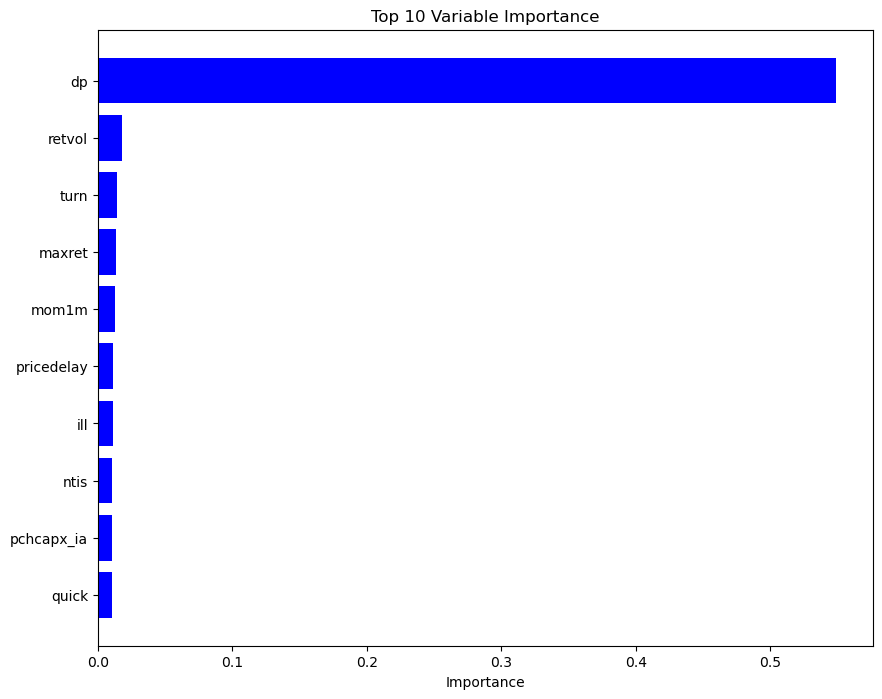

In [16]:
# Extracting feature names and their corresponding importance scores
features = [var[1] for var in top_10_important_vars]
feature_names = [var[0] for var in features]  # Extract variable names
importances = [var[1] for var in features]  # Extract importance scores

# Plotting the data as a horizontal bar chart
plt.figure(figsize=(10, 8))  # Set the size of the figure
plt.barh(feature_names, importances, color='blue')  # Create a horizontal bar chart with blue bars
plt.xlabel('Importance')  # Label for the x-axis
plt.title('Top 10 Variable Importance')  # Title of the chart
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important variable at the top
plt.show()  # Display the plot

Second, get a measure of the joint importance of all our “macro predictors” (i.e., those taken from Welch and Goyal 2008), by setting them all to zero and finding the decrease in out of sample R2. Comment on how important macroeconomic variables are relative to stock characteristics in predicting returns. 

In [7]:
def macro_importance(X, y, model, macro_variables, baseline_r2):
    importance = {}
    
    X_temp = X.copy()
    
    # Iterate over macro features
    for var in macro_variables:
        if var in X_NN.columns:
            indices = X_NN.columns.get_loc(var)
            print("Eliminating macro variables:")
            print(X_NN.columns[indices])
            X_temp[:, indices] = 0
    
        
    y_pred = model.predict(X_temp)
        
    ss_res = np.sum((y - y_pred.T) ** 2)
    ss_tot = np.sum((y) ** 2)
    r2_out_of_sample = 1 - (ss_res / ss_tot)
        
    # "Importance" is the decrease in OOS R2
    importance = baseline_r2 - r2_out_of_sample
        
    print(f"Setting all macro predictors to zero. New R²: {r2_out_of_sample}, Joint Importance: {importance}")

    return importance

# Get the macro variables
# Note: "date" does not include in macro variables
macro_variables = macro_data.columns
macro_variables = macro_variables.drop("date")
print("Starting to drop macro variables:")
print(macro_variables)

# Calculate variable importance for the best model
joint_importance = macro_importance(X_test, y_test, model=NN_2, macro_variables=macro_variables, baseline_r2=r2_oos_2_mean)

joint_importance

Starting to drop macro variables:
Index(['dp', 'ep', 'b/m', 'crsp_spvw', 'svar', 'tbl', 'tms', 'dfy', 'dfr',
       'ntis', 'infl'],
      dtype='object')
Eliminating macro variables:
dp
Eliminating macro variables:
b/m
Eliminating macro variables:
crsp_spvw
Eliminating macro variables:
svar
Eliminating macro variables:
tbl
Eliminating macro variables:
tms
Eliminating macro variables:
dfy
Eliminating macro variables:
dfr
Eliminating macro variables:
ntis
Eliminating macro variables:
infl
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step
Setting all macro predictors to zero. New R²: -0.43675199170945045, Joint Importance: 0.41168987446080263


0.41168987446080263